In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline

### dataloader analysis

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']=""
import torchvision
torchvision.set_image_backend('accimage')

from utils.extras import *
from datasets.dataset_factory import *
import time


In [4]:
phase = "train"

class Parser(): # jugaad for get_parser in jupyter
    filepath = '../configs/test.yaml'
# args = get_parser()
args = Parser()
cfg = load_cfg(args)
cfg["num_workers"] = 0
cfg["batch_size"]["train"] = 2
cfg["batch_size"]["val"] = 2

df = pd.read_csv(str(cfg.home / cfg.df_path))
dataloader = provider(df, phase, cfg)

{   'base_lr': 'None',
    'batch_size': {'test': 4, 'train': 8, 'val': 4},
    'class_weights': 'None',
    'cw_sampling': False,
    'data_folder': PosixPath('data/train_npy'),
    'data_home': PosixPath('/media/ags/DATA/CODE/kaggle/species-audio-detection'),
    'df_path': PosixPath('data/train_df.csv'),
    'ep2unfreeze': 2,
    'ext_text': 'test',
    'fold': 0,
    'hard_df': 'weights/',
    'hard_ex_weight': 2,
    'he_sampling': False,
    'home': PosixPath('/media/ags/DATA/CODE/kaggle/species-audio-detection'),
    'loss': {'name': 'focal_loss', 'params': {'gamma': 2.0}},
    'mean': '(0.485, 0.456, 0.406)',
    'model_name': 'efficientnet-b3',
    'momentum': 0.95,
    'num_classes': 24,
    'num_epochs': 100,
    'num_samples': 'None',
    'num_workers': 8,
    'optimizer': {'name': 'RAdam', 'params': {'lr': 0.001}},
    'patience': 3,
    'phases': ['train', 'val'],
    'remark': 'Testing',
    'sample_submission': PosixPath('data/sample_submission.csv'),
    'size': [128, 

In [5]:
''' train val set sanctity
#pdb.set_trace()
tdf = dataloader.dataset.df
phase = "val"
dataloader = provider(phase, cfg)
vdf = dataloader.dataset.df
print(len([x for x in tdf.id_code.tolist() if x in vdf.id_code.tolist()]))
exit()
'''

' train val set sanctity\n#pdb.set_trace()\ntdf = dataloader.dataset.df\nphase = "val"\ndataloader = provider(phase, cfg)\nvdf = dataloader.dataset.df\nprint(len([x for x in tdf.id_code.tolist() if x in vdf.id_code.tolist()]))\nexit()\n'

In [6]:
total_labels = []
total_len = len(dataloader)
from collections import defaultdict
fnames_dict = defaultdict(int)
batch = next(iter(dataloader))
fnames, images, labels = batch

In [7]:
fnames

('a2a211fa8', 'bffdcd085')

In [8]:
images.shape, labels.shape

(torch.Size([2, 3, 128, 376]), torch.Size([2, 24]))

##### let's plot these images

In [9]:
images.min(), images.max(), images.mean(), images.std()

(tensor(-3.3741), tensor(-1.5405), tensor(-2.4065), tensor(0.1869))

In [10]:
plt.imshow(images[0, 0, :, :])

In [11]:
org_img = np.load(f'../data/train_npy/{fnames[0]}.npy')

In [22]:
org_img.shape, org_img.min(), org_img.max(), org_img.mean()

((128, 376), -53.701836, 26.298162, -12.386973)

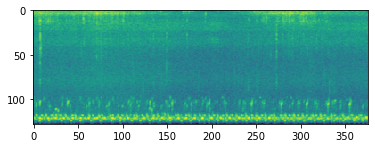

In [24]:
plt.imshow(org_img)

### df creation

In [63]:
train_tp = pd.read_csv('../data/train_tp.csv')
train_fp = pd.read_csv('../data/train_tp.csv')
sample = pd.read_csv('../data/sample_submission.csv')

In [3]:
train_tp.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [16]:
train_tp['species_id'].nunique() # total species

24

In [26]:
rows_idx


Int64Index([0], dtype='int64')

In [32]:
rec_id, rows_idx

('003bec244',
   recording_id  species_id  songtype_id   t_min    f_min    t_max    f_max
 0    003bec244          14            1  44.544  2531.25  45.1307  5531.25)

In [33]:
grps = train_tp.groupby('recording_id')

for rec_id, grp in grps:#.groups.items():
    species = grp['species_id'].values
    break

In [34]:
grp['species_id']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.544,2531.25,45.1307,5531.25


In [73]:
# row['recording_id']
row[1]

recording_id    003bec244
species_id             14
Name: 0, dtype: object

In [76]:

ids = defaultdict(lambda: [0] * 24)
for idx, row in train_tp.iterrows():
    ids[row['recording_id']][row['species_id']] = 1
    

In [109]:
df = pd.DataFrame(ids).T
df.columns = [f's{i}' for i in range(24)]
df['recording_id'] = df.index # add id column
df.reset_index(drop=True, inplace=True) # remove index
df = df[['recording_id'] + [f's{i}' for i in range(24)]] # rearrange
df.head()

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,006ab765f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,007f87ba2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0099c367b,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,009b760e6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# df.to_csv('../data/train_df.csv', index=False)

In [112]:
'c68fb36e7' in train_tp['recording_id'].values


True

In [132]:
folder = Path('../data/train_npy/')

In [139]:
files = folder.glob('*.npy')

In [140]:
files = [s.stem for s in files]

In [141]:
files == list(set(train_tp.recording_id))

False

In [142]:
for f in list(train_tp.recording_id):
    if f not in files:
        print(f)
        

003bec244
006ab765f
007f87ba2
0099c367b
009b760e6
00b404881
00d442df7
011f25080
015113cad
0151b7d20
01b41f92b
0201197ec
0209f7ab2
0268057eb
0275e127d
0295e3234
0297d886e
02b9a8ab9
0313e82cf
03b96f209
03b96f209
03d77fede
043356ff8
04975ecd8
04d6b1fc1
04e70a8e3
0509303a5
050d0ca85
053aeb7bd
053aeb7bd
055088446
055d22517
057802c25
05b9c974c
05f8c0f2f
067f49f8b
068f1b8e2
06a0c48c9
06c44d203
073e4d908
078788674
07d1687e0
07dcf40f7
07f1227b0
08db743d0
090ae427d
09315d9bf
0968aea09
09a946316
0a350d11c
0a9cdd8a5
0ab6aa734
0b2fa3f80
0b3ef9c4e
0c2124550
0c448e77c
0c48ed342
0c936a1d4
0cb4632d6
0d25045a9
0e034f968
0e29d05ed
0e2e4ac19
0e799da44
0ea8ea68a
0eb2079ea
0f8cadb4a
0f99800b7
0fc62dd3c
100e4ddc9
103db6411
10dae79ed
119b154cc
11a52d37a
11bafff5d
11c2c02e5
11c2c02e5
1263c23c8
12a12f0fa
12ec1d4cb
133001416
13511f7bd
1375a05d1
1383208d3
13c678c1d
13de5cabb
13f64f898
1414bbe17
141675c80
147b41b13
14948ff80
14d467153
14dc5a39e
14f6cbe5c
1504619b7
1520a52ef
1535d0c9b
1545e29b3
156b77dfe
157a50231


In [136]:
for f in files:
    if f not in list(train_tp.recording_id):
        print(f)
        

f109f8584
b6a5fed59
96c46c2cd
ca3ef87e7
c07e51d93
2037a18e6
071823da4
4cfc749c3
d6713bfd9
66ef262ad
f61b72beb
fae58971a
319e88027
ad39ad527
6025334a0
a3403ba21
50d053fd6
a227d1315
dd9f4942e
f68c23276
dce0408a7
78af9003f
9bdcec22b
5ab5c078a
8bf114c9c
65394fb73
14bd9c39c
25aabb1b5
f4714d970
271bcbb29
438832119
0e5a03b1f
8eab581da
83d802b00
e143ced0e
8d5cd37e3
6ff194238
352a7358d
e306bcecd
667cb9ba7
364e10d4b
f8e231afe
2f4514532
600f1b8f6
d17bcb8cd
cae7b4e19
f0e65ccad
513b7f687
834be2097
5f9bf846a
cb9d233f8
e744f47c3
50bf7744e
3b5037d3e
ce66ba21f
064d24348
e21d56910
ec2feba84
5e94a23dd
f76471a24
170de6438
28974b8b6
4071f7aa7
976e26167
5579e3a0a
ae81919a7
fed5d1b9c
7eebebc13
b42aa0f8b
ffc6031f8
16793f0bf
67205f705
d7608d53a
eb50c4520
fbbca0c89
3a3848189
1076d38c9
d564cf618
091d8cc72
d810b6166
c3998738f
38bbedd15
032cb2915
fa9513274
edd568403
da0e9125f
955cbc31c
7842a2fc4
c9759e60a
87149f344
6a5511f58
972043240
5d1cb6a21
bb5c92a56
2753487e1
dc0f0eb69
87a34209d
11fd2b63e
8c5f9d5a1
f3f42968a


180d82dca
de7922c14
7824bd6ff
eb685f870
aa499f21b
ebb21fb4d
bf2c17c1e
face9266f
27eb32774
14809568f
8d1192f16
5597fd8be
71917c271
f1de9d996
712724292
53d3c160a
1171e7dfa
207c8241d
d69958c40
6f423ed00
a07a6bdf1
be2a26a83
48fb7aa8d
c06d6231c
d5fa60cbb
28250a178
91e11cabb
f4dd82c85
632af67c7
2dfdea18c
4261df85b
391674704
e13ccd805
dda5e1734
450fe6a1e
fcea8888b
5b6a0c5b2
038dfd032
362f353f4
d0c83b812
837d77a0e
3641f60b7
62de3f962
6ffa765d0
6645f0d5d
fd59168d0
865a1925f
1d8e04120
c238df4c4
f851b0095
f6789d4ac
3f0f6e73d
bc3f9bc70
939659635
11f1747a9
022f801bc
ae19625f5
091a9a48c
f2d986715
437cab912
4d55c368e
0b5a33bb8
4f8277098
a848bca7d
a339d1955
0d5f3f252
6fd0e4a7f
0e4a29539
89a0cb4e3
5f32514a2
1cf65a85a
a71b252e5
b94e40f71
c81ca80f1
6b46c794b
67bed7868
f000113e5
999bac2e2
534ffb33a
1a0b72e93
1e79a2c16
860ab9160
78a2c3199
7e60a570a
5a21862a1
5adafbf1c
800113ec0
e4b068a86
65123b656
b8cdab936
4a53528d1
65f32be6d
13acead83
d010a0b49
e572a2c20
c3c740138
b64238c47
ee8e42ab9
5a576841e
87308716b


8e0e7cc78
0b3479649
346b22fb5
3da9950ab
b113aaf6c
b97d95a72
cded42600
8010eae3f
af6b32ad4
fc302ff12
7675c01d1
6d911c10a
17984a6e7
930dba892
14c397838
5b00d77fa
96732714b
abf0f1580
c0abfe433
62ad21b63
89577bade
9fd2d3daa
1964b83e1
f9f2bfa12
88e6d1799
08f1d28d2
1ea2f04c3
dd08226bf
c802acaf5
da3066ce7
f1be0a6f7
490f97b89
708e4dd42
3ce447771
9769745d4
e34ea9272
0a98ad3b6
ad5ecca53
cbc0ccff3
b6c544259
ea26b19ee
e77061ecf
48993ec06
5c9a45273
fa4e32383
e8799a715
b209ec922
31eb94279
f5226c724
ae8fd3a51
6c321d828
f479ea4be
ed5627ec7
2be83e588
4b557883e
b6aa1c73f
1295eddd3
887a57272
0a29fd478
6dc1f9567
65daa4d4d
7f044bada
fa1776098
5dceb7427
a2eb73066
46ffa7ac9
049bbf288
88c662e98
56333906d
f63c7ca2f
01e8c8d72
cf1d720cb
51a733aa1
88c690603
17e28efe7
e6998cb3d
a5960d4d9
86fd48bef
6df1f68bd
0a9143370
1f0b4199d
d24f6dbff
074cf066a
2cff7e7b4
f4a8d9893
1f7abf062
c6c9303f7
48fa3d998
c3ff0bb6e
7ee83b7de
00204008d
3889ed72c
ff22519ea
c8a178afd
61a1d22ce
51cb31962
5737e04cd
73abadb47
8250cac8d
0cf1a2ecd


In [57]:
train_tp.tail()

,recording_id,species_id
1211,fe8d9ac40,13
1212,fea6b438a,4
1213,ff2eb9ce5,0
1214,ffb8d8391,5
1215,ffb9a7b9a,18


In [58]:
train_tp['species_id'].values

array([14, 23, 12, ...,  0,  5, 18])

In [59]:
one_hot = MultiLabelBinarizer()
one_hot.fit_transform(train_tp['species_id'].values)

TypeError: 'numpy.int64' object is not iterable

In [5]:
img_path = '../data/train_npy/' + train_tp['recording_id'][0] + '.npy'

In [6]:
img = np.load(img_path)

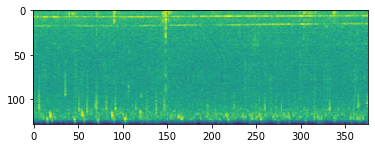

In [8]:
plt.imshow(img)

In [143]:
img.shape


(128, 376)

In [154]:

# iimg = np.repeat(img, 3, axis=2)
iimg = np.stack([img, img, img], axis=2)

In [155]:
iimg.shape

(128, 376, 3)